In [2]:
# importing the necessary libraries
import pandas as pd
import re
import string
import nltk        
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report 
import zipfile
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
#Reading the file
file_path = r'C:\Users\Julie Musangi\Desktop\DS Course Material\Phase-5\consumer_complaints_analysis\data_comp.zip'

with zipfile.ZipFile(file_path) as z:
    data = pd.read_csv(z.open('consumer_complaints.csv'), index_col=0)

## Data Exploration

In [4]:
# Checking the first 5 rows
data.head()

,product,narrative
0,credit_card,purchase order day shipping amount receive pro...
1,credit_card,forwarded message date tue subject please inve...
2,retail_banking,forwarded message cc sent friday pdt subject f...
3,credit_reporting,payment history missing credit report speciali...
4,credit_reporting,payment history missing credit report made mis...


- The dataset has 2 columns, product and narrative (customer complaint)

In [5]:
#Checking the information about the DataFrame
data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 162421 entries, 0 to 162420
Data columns (total 2 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   product    162421 non-null  object
 1   narrative  162411 non-null  object
dtypes: object(2)
memory usage: 3.7+ MB


- The dataFrame contains 162421 rows, and 2 columns both of the object datatype

In [6]:
# Checking for null values
data.isna().sum()

product       0
narrative    10
dtype: int64

- DataFrame contains 10 null values in the narrative column. These will be delt with during data cleaning

In [7]:
#Dropping the null values since they make a small proportion
data.dropna(inplace=True)
data.isna().sum()

product      0
narrative    0
dtype: int64

In [8]:
#Checking for duplicates
data.duplicated().sum()

37735

- The DataFrame has 37735 duplicates. I will drop the duplicates in the following section

In [9]:
data.drop_duplicates(subset=['product', 'narrative'], inplace= True) #Dropping the duplicates
data.shape # Checking the shape of the df after dropping duplicates

(124676, 2)

In [10]:
#Checking for unique values in the product column
data['product'].unique()

array(['credit_card', 'retail_banking', 'credit_reporting',
       'mortgages_and_loans', 'debt_collection'], dtype=object)

- The DataFrame contains customer complaints directed to 5 product offerings; `credit cards` , `retail banking` , `credit reporting` , `morgages and loans` , and `debit collection`. 

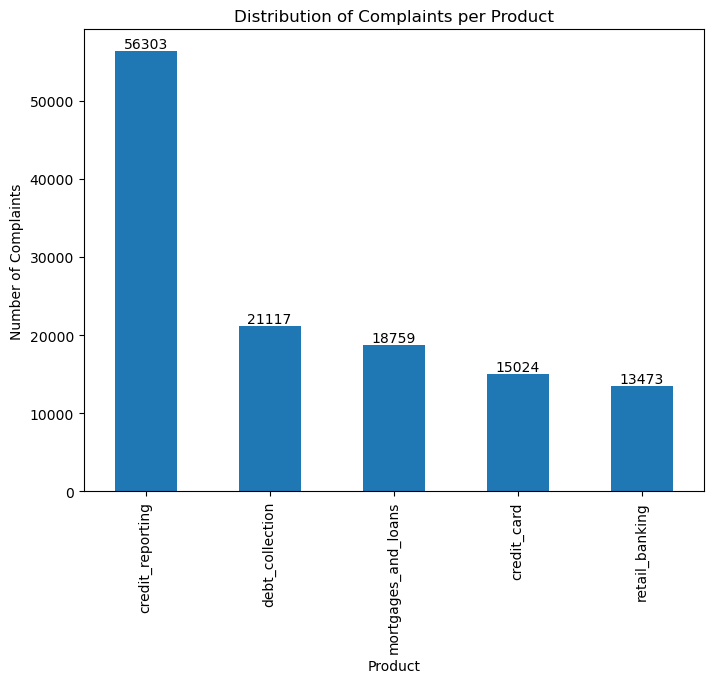

In [11]:
# plotting the distribution of complaints per product
complaints = data['product'].value_counts()

plt.figure(figsize=(8, 6))
ax = complaints.plot(kind='bar')
plt.title('Distribution of Complaints per Product')
plt.xlabel('Product')
plt.ylabel('Number of Complaints')
plt.xticks(rotation=90)

# Add count labels on top of each bar
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom')

plt.show()

- The bar graph shows that majority of the customer complaints are in regard to credit reporting. The number is significantly larger than the rest of the product offerings, which range from 13,536 to 23,150.

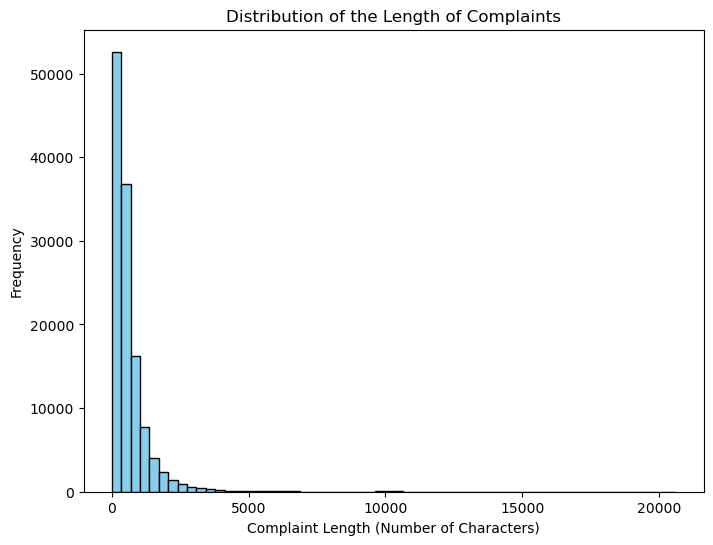

In [12]:
# Checking the distribution of the length of complaints
complaint_length = data['narrative'].str.len()

# Plot the distribution of tweet lengths
plt.figure(figsize=(8, 6))
plt.hist(complaint_length, bins = 60, color='skyblue', edgecolor='black')
plt.title('Distribution of the Length of Complaints')
plt.xlabel('Complaint Length (Number of Characters)')
plt.ylabel('Frequency')
plt.show()

- Most customer complaints appear to be short in length, with only a small fraction of complaints being detailed or lengthy. This may suggest that customers tend to keep their complaints concise, or it could indicate specific complaint types that are resolved with fewer words.

## Text Preprocessing

In [13]:
# Importing relevant libraries for text preprocessing
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Downloading NLTK resources
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

# Instantiating stop words and lemmatizer
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to C:\Users\Julie
[nltk_data]     Musangi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to C:\Users\Julie
[nltk_data]     Musangi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to C:\Users\Julie
[nltk_data]     Musangi\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [14]:
# Defining the Text Preprocessing Function
def preprocess_text(text):
    text = text.lower()  # Convert to Lowercase
    text = re.sub(r'[^\w\s]', '', text)  # To remove punctuation
    words = word_tokenize(text)  # Tokenize
    words = [w for w in words if not w in stop_words]  # Remove stopwords
    words = [lemmatizer.lemmatize(w) for w in words]  # Lemmatize
    return ' '.join(words)

# Applying Text Preprocessing
data['cleaned_narrative'] = data['narrative'].apply(preprocess_text)

# Displaying a sample of the cleaned narratives
data[['narrative', 'cleaned_narrative']].head()

,narrative,cleaned_narrative
0,purchase order day shipping amount receive pro...,purchase order day shipping amount receive pro...
1,forwarded message date tue subject please inve...,forwarded message date tue subject please inve...
2,forwarded message cc sent friday pdt subject f...,forwarded message cc sent friday pdt subject f...
3,payment history missing credit report speciali...,payment history missing credit report speciali...
4,payment history missing credit report made mis...,payment history missing credit report made mis...


In [15]:
%pip install wordcloud


Note: you may need to restart the kernel to use updated packages.


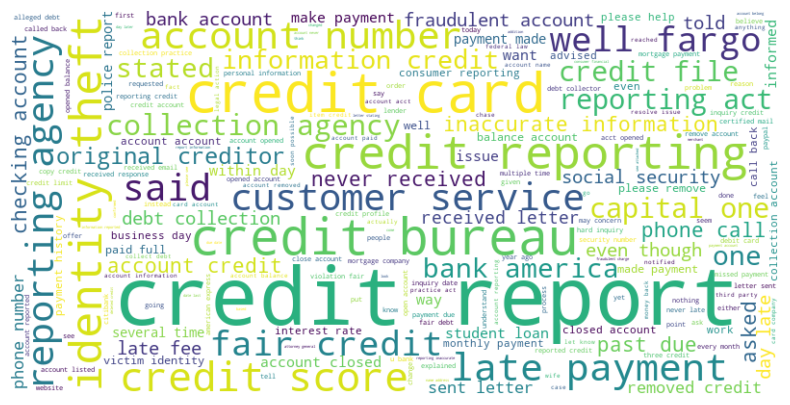

In [16]:
from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=400, background_color="white").generate(' '.join(data['cleaned_narrative']))
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

- This word cloud reveals that consumer complaints in the dataset predominantly revolve around credit-related issues, such as credit reporting, credit scores, and identity theft, indicating frequent problems in these areas. Terms like "credit bureau," "credit report," and "identity theft" suggest ongoing concerns with credit accuracy, score management, and identity protection. Additionally, financial institutions like Wells Fargo, Capital One, and Bank of America feature prominently, implying that these companies receive a substantial volume of complaints, possibly due to recurring issues or a large customer base. Common grievances include poor customer service, debt collection practices, billing issues, and fraud, highlighted by terms like "customer service," "late payment," and "collection agency." These insights suggest that credit and identity issues, along with financial service complaints, are significant pain points for consumers in this dataset.

## Splitting the Data & Feature Engineering

In [17]:
# Train-Test Split
X_train_text, X_test_text, y_train, y_test = train_test_split(data['cleaned_narrative'], data['product'], test_size=0.3, random_state=42)

# Feature Engineering
tfidf = TfidfVectorizer(max_features=5000)
X_train = tfidf.fit_transform(X_train_text) 
X_test = tfidf.transform(X_test_text)  